## **Fynbos within Plot Diversity Assesment**

In [8]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [9]:
#rioxarray wasn't importing automatically

!pip install rioxarray

In [10]:
## importing packages

import os
os.environ['USE_PYGEOS'] = '0'
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
# import fiona
# from fiona import Feature, Geometry
from shapely.geometry import mapping
import rioxarray as rxr
import xarray as xr
import geopandas as gpd
import rasterio as rio
from rasterio.enums import Resampling

In [11]:
## Predefined plot preferences--> This is my usual plot preference

# Define text sizes
SMALL_SIZE = 14
MEDIUM_SIZE = 16
BIGGER_SIZE = 18

# Apply text size settings
plt.rc('font', size=SMALL_SIZE)          # Default font size
plt.rc('axes', titlesize=MEDIUM_SIZE)   # Axis title font size
plt.rc('axes', labelsize=MEDIUM_SIZE)   # Axis labels font size
plt.rc('xtick', labelsize=SMALL_SIZE)   # X-axis tick label font size
plt.rc('ytick', labelsize=SMALL_SIZE)   # Y-axis tick label font size
plt.rc('legend', fontsize=SMALL_SIZE)   # Legend font size
plt.rc('figure', titlesize=BIGGER_SIZE) # Figure title font size

In [12]:
top_path='/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis/'

## Path to my structural metrics maps
chm_raster_path = top_path + f'/burns_lr/results_0.25m/chm'
tr_raster_path = top_path + f'/burns_lr/results_0.25m/tr'
pd_raster_path = top_path + f'/burns_lr/results_0.25m/pd'
gf_raster_path = top_path + f'/burns_lr/results_0.25m/gf'

## Read all metrics rasters

## Canopy heights:

chm_2016 = chm_raster_path + '/chm_2016.tif'
chm_17_16 = chm_raster_path + '/chm_17_16.tif'
chm_2017 = chm_raster_path + '/chm_2017.tif'
chm_2018 = chm_raster_path + '/chm_2018.tif'
chm_2019 = chm_raster_path + '/chm_2019.tif'
chm_2022 = chm_raster_path + '/chm_2022.tif'


## top rugosity:

tr_2016 = tr_raster_path + '/tr_2016.tif'
tr_17_16 = tr_raster_path + '/tr_17_16.tif'
tr_2017 = tr_raster_path + '/tr_2017.tif'
tr_2018 = tr_raster_path + '/tr_2018.tif'
tr_2019 = tr_raster_path + '/tr_2019.tif'
tr_2022 = tr_raster_path + '/tr_2022.tif'


## internal heterogeneity:

pd_2016 = pd_raster_path +  '/pd_2016.tif'
pd_17_16 = pd_raster_path +  '/pd_17_16.tif'
pd_2017 = pd_raster_path +  '/pd_2017.tif'
pd_2018 = pd_raster_path +  '/pd_2018.tif'
pd_2019 = pd_raster_path +  '/pd_2019.tif'
pd_2022 = pd_raster_path +  '/pd_2022.tif'


## Gap Fraction:

gf_2016 = gf_raster_path + '/gf_2016.tif'
gf_17_16 = gf_raster_path + '/gf_17_16.tif'  ## year 2017 and 2016
gf_2017 = gf_raster_path + '/gf_2017.tif'  ## plot17
gf_2018 = gf_raster_path + '/gf_2018.tif'  ## plot18
gf_2019 = gf_raster_path + '/gf_2019.tif'
gf_2022 = gf_raster_path + '/gf_2022.tif'


## Heights in sample plot
h_2016 = 1.25
h_2006 = 2.0
h_2020 = 0.4
h_2017 = 0.65
h_2019 = 0.3

In [13]:
#load shapefiles:

shp_2022 = gpd.read_file('/content/drive/MyDrive/Fynbos/October_2023/Grootbos_Drone_files/mavic3m/burn2022_lr/shapefiles/burn2022_lr_shape_all/burn2022_lr_shp.shp')
shp_2016 = gpd.read_file('/content/drive/MyDrive/Fynbos/October_2023/Grootbos_Drone_files/mavic3m/burn2016_lr/shapefiles/burn2016_lr_shape_all/burn2016_shp.shp')
shp_17_16 = gpd.read_file('/content/drive/MyDrive/Fynbos/October_2023/Grootbos_Drone_files/mavic3m/burn2017&2016_lr/shapefiles/burn2017_shape/burn2017_shp.shp') # year 2016 second plot
shp_2018 = gpd.read_file('/content/drive/MyDrive/Fynbos/October_2023/Grootbos_Drone_files/mavic3m/burnplot18_lr/shapefiles/burnplot18_lr_shape_all/burnplot18_lr_shp.shp')
shp_2019 = gpd.read_file('/content/drive/MyDrive/Fynbos/October_2023/Grootbos_Drone_files/mavic3m/burn2019_lr/shapefiles/burn2019_lr_shape_all/burn2019_lr_shp.shp')
shp_2017 = gpd.read_file('/content/drive/MyDrive/Fynbos/October_2023/Grootbos_Drone_files/mavic3m/burnplot17_lr/shapefiles/burnplot17_lr_shape_all/burnplot17_lr_shp.shp')

In [14]:
## For each small 5 * 5 plots calculate the mean of each maps

def plot_level_metric_mean(metrics_map, shape_file):
  raster = rxr.open_rasterio(metrics_map, masked = True).squeeze()
  geometries = shape_file.geometry.apply(mapping)
  mean_metric_values = []
  std_values = []
  plots = []

  for i in range(len(geometries)):

    plot = raster.rio.clip([geometries[i]], shape_file.crs)
    plot_array = np.asarray(plot)

    mean = np.nanmean(plot_array)
    std = np.nanstd(plot_array)

    mean_metric_values.append(mean)
    std_values.append(std)
    plots.append(i+1)

  return mean_metric_values, std_values, plots

In [15]:
# year 2022
mean_chm_2022, subplot_chm_std_2022, plots_2022 = plot_level_metric_mean(chm_2022, shp_2022)
mean_tr_2022, subplot_tr_std_2022, _= plot_level_metric_mean(tr_2022, shp_2022)
mean_pd_2022,subplot_pd_std_2022, _= plot_level_metric_mean(pd_2022, shp_2022)
mean_gf_2022, subplot_gf_std_2022,_= plot_level_metric_mean(gf_2022, shp_2022)

# year 2016
mean_chm_2016, subplot_chm_std_2016, plots_2016 = plot_level_metric_mean(chm_2016, shp_2016)
mean_tr_2016,subplot_tr_std_2016, _= plot_level_metric_mean(tr_2016, shp_2016)
mean_pd_2016,subplot_pd_std_2016, _= plot_level_metric_mean(pd_2016, shp_2016)
mean_gf_2016, subplot_gf_std_2016, _= plot_level_metric_mean(gf_2016, shp_2016)

# plot 18 -->2018 (year 2006)
mean_chm_2018,subplot_chm_std_2018, plots_2018 = plot_level_metric_mean(chm_2018, shp_2018)
mean_tr_2018,subplot_tr_std_2018, _= plot_level_metric_mean(tr_2018, shp_2018)
mean_pd_2018,subplot_pd_std_2018, _= plot_level_metric_mean(pd_2018, shp_2018)
mean_gf_2018,subplot_gf_std_2018, _= plot_level_metric_mean(gf_2018, shp_2018)


In [16]:
# year 2019
mean_chm_2019,subplot_chm_std_2019, plots_2019 = plot_level_metric_mean(chm_2019, shp_2019)
mean_tr_2019,subplot_tr_std_2019, _= plot_level_metric_mean(tr_2019, shp_2019)
mean_pd_2019,subplot_pd_std_2019, _= plot_level_metric_mean(pd_2019, shp_2019)
mean_gf_2019,subplot_gf_std_2019, _= plot_level_metric_mean(gf_2019, shp_2019)

# year 2016v2
mean_chm_17_16,subplot_chm_std_17_16, plots_17_16 = plot_level_metric_mean(chm_17_16, shp_17_16)
mean_tr_17_16,subplot_tr_std_17_16, _= plot_level_metric_mean(tr_17_16, shp_17_16)
mean_pd_17_16,subplot_pd_std_17_16, _= plot_level_metric_mean(pd_17_16, shp_17_16)
mean_gf_17_16,subplot_gf_std_17_16, _= plot_level_metric_mean(gf_17_16, shp_17_16)

# plot 17 (year 2020)
mean_chm_2017, subplot_chm_std_2017, plots_2017 = plot_level_metric_mean(chm_2017, shp_2017)
mean_tr_2017, subplot_tr_std_2017, _= plot_level_metric_mean(tr_2017, shp_2017)
mean_pd_2017, subplot_pd_std_2017, _= plot_level_metric_mean(pd_2017, shp_2017)
mean_gf_2017, subplot_gf_std_2017, _= plot_level_metric_mean(gf_2017, shp_2017)

/tmp/ipython-input-2611307585.py:15: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(plot_array)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2611307585.py:15: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(plot_array)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2611307585.py:15: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(plot_array)
/usr/local/lib/python3.11/dist-packages/numpy/lib/_nanfunctions_impl.py:2035: RuntimeWarning: Degrees of freedom <= 0 for slice.
  var = nanvar(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/tmp/ipython-input-2611307585.py:15: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(plot_array)
/usr/lo

**Metrics Variations with Burn Years**

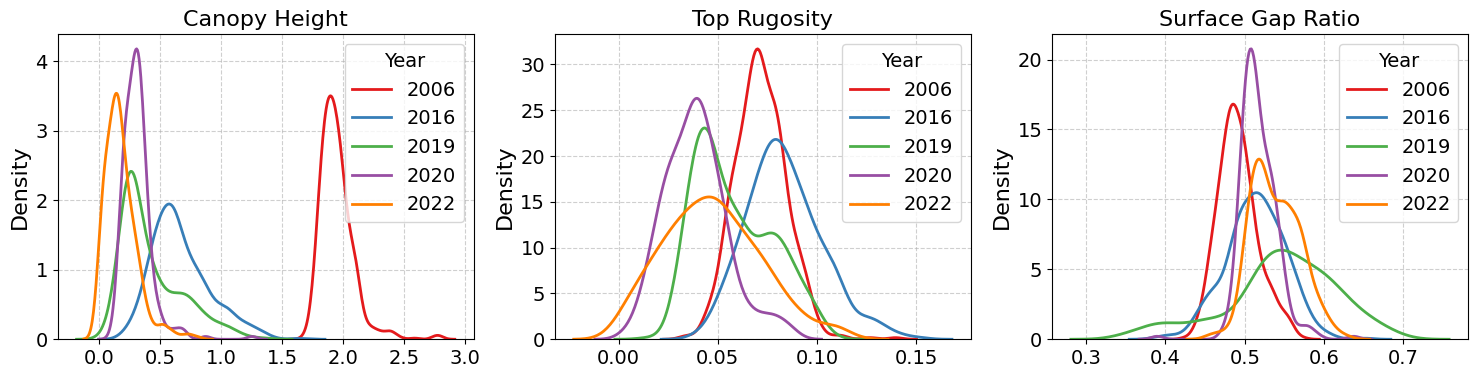

In [17]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

# Your data for each year
data_years = {
    2006: {'chm': np.array(mean_chm_2018), 'tr': np.array(mean_tr_2018), 'gr': np.array(mean_gf_2018), 'pd': np.array(mean_pd_2018)},
    2016: {'chm': np.array(mean_chm_2016), 'tr': np.array(mean_tr_2016), 'gr': np.array(mean_gf_2016), 'pd': np.array(mean_pd_2016)},
    2019: {'chm': np.array(mean_chm_2019), 'tr': np.array(mean_tr_2019), 'gr': np.array(mean_gf_2019), 'pd': np.array(mean_pd_2019)},
    2020: {'chm': np.array(mean_chm_2017), 'tr': np.array(mean_tr_2017), 'gr': np.array(mean_gf_2017), 'pd': np.array(mean_pd_2017)},
    2022: {'chm': np.array(mean_chm_2022), 'tr': np.array(mean_tr_2022), 'gr': np.array(mean_gf_2022), 'pd': np.array(mean_pd_2022)},
}


# Set seaborn style
# sns.set(style='whitegrid', font_scale=1.2, rc={'figure.figsize': (15, 5)})

# Metrics to plot
metrics = ['chm', 'tr', 'gr']  # use ['chm', 'tr', 'gr', 'pd'] for all four
metric_labels = {'chm': 'Canopy Height', 'tr': 'Top Rugosity', 'gr': 'Surface Gap Ratio'}

# Set color palette
palette = sns.color_palette("Set1", len(data_years))
year_colors = dict(zip(sorted(data_years.keys()), palette))

# Create subplots
fig, axes = plt.subplots(1, len(metrics), figsize=(15, 4), sharey=False)

# Plot KDEs for each metric
for i, metric in enumerate(metrics):
    ax = axes[i]
    for year in sorted(data_years.keys()):
        sns.kdeplot(data_years[year][metric], label=f'{year}', ax=ax, color=year_colors[year], lw=2)

    ax.set_title(metric_labels[metric])
    ax.set_ylabel('Density')
    ax.legend(title='Year')
    ax.grid(True, linestyle='--', alpha=0.6)

plt.tight_layout()
# plt.suptitle("KDE Plots of Vegetation Metrics Across Years", fontsize=16, fontweight='bold', y=1.05)
# plt.subplots_adjust(top=0.88)
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/metric_variation_wburnyears.png', dpi=500)
plt.show()



In [18]:
## For each Plot combine all four structural metrices to single array

bdata_2022 = [ [mean_chm_2022[i], mean_tr_2022[i], mean_pd_2022[i], mean_gf_2022[i]] for i in range(len(plots_2022))]
bdata_2016 = [ [mean_chm_2016[i], mean_tr_2016[i], mean_pd_2016[i], mean_gf_2016[i]] for i in range(len(plots_2016))]
bdata_2018 = [ [mean_chm_2018[i], mean_tr_2018[i], mean_pd_2018[i], mean_gf_2018[i]] for i in range(len(plots_2018))]
bdata_2019 = [ [mean_chm_2019[i], mean_tr_2019[i], mean_pd_2019[i], mean_gf_2019[i]] for i in range(len(plots_2019))]
bdata_17_16 = [ [mean_chm_17_16[i], mean_tr_17_16[i], mean_pd_17_16[i], mean_gf_17_16[i]] for i in range(len(plots_17_16))]
bdata_2017 = [ [mean_chm_2017[i], mean_tr_2017[i], mean_pd_2017[i], mean_gf_2017[i]] for i in range(len(plots_2017))]

In [19]:
## Alpha Diversity of Reference Plots

## Truth Data

abundance_2006 = [18, 16, 25, 2, 12, 1, 5, 8, 3, 1, 3, 1]
percent_cover_2006 = [12, 10, 30, 0.5, 13, 5, 4, 3, 0.5, 5, 1, 1]

abundance_2016_v1 = [16, 22, 3, 6, 2, 25, 15, 3, 5, 1, 3, 1, 1]
percent_cover_2016_v1 = [15, 23, 1, 6, 5, 10, 8, 1, 5.75, 2, 1, 2, 0.25]

abundance_2016_v2 = [5, 7, 9, 1, 45, 4, 4, 2, 13, 2, 6, 1, 1, 2, 1, 1]
percent_cover_2016_v2 = [6, 5, 15, 3, 26, 3, 1, 6, 3, 2, 10, 2, 0.25, 0.75, 1, 4]


abundance_2019 = [10, 15, 5, 30, 45, 4, 4, 10, 4, 2]
percent_cover_2019 = [1, 0.25, 2, 46, 10, 5, 4, 1, 0.25, 0.5]

abundance_2020 = [16, 10, 4, 22, 14, 35, 4, 15, 3, 22, 25, 3]
percent_cover_2020 = [3, 6, 0.5, 25, 2, 4, 4, 1.5, 5, 6, 2, 1]

percent_cover_2022 = [2, 5, 7, 20, 0.5, 1, 0.7, 3, 0.5, 4, 0.8, 0.7, 0.5, 5, 1, 0.80]

# Calculate Shannon Diversity Index for each year ---> alpha diversity

def shannon_diversity_index(abundances):

    abundances = np.array(abundances)
    total_abundance = np.sum(abundances)
    proportions = abundances / total_abundance
    ln_proportions = np.log(proportions)
    shannon_diversity = -np.sum(proportions * ln_proportions)

    return shannon_diversity

# Reference plot shannon diversity-values: Percent cover based
shannon_2018 = shannon_diversity_index(percent_cover_2006)
shannon_2016 = shannon_diversity_index(percent_cover_2016_v1)
shannon_2016_v2 = shannon_diversity_index(percent_cover_2016_v2)
shannon_2019 = shannon_diversity_index(percent_cover_2019)
shannon_2020 = shannon_diversity_index(percent_cover_2020)
shannon_2022 = shannon_diversity_index(percent_cover_2022)

# Shannon Diversity Index: percenyage cover based
div = [shannon_2018, shannon_2016, shannon_2016_v2, shannon_2019, shannon_2020]
shannon_DI = np.array(div)

# Reference plot shannon diversity-values: Abundance cover based: NI
shannon_2018_abd = shannon_diversity_index(abundance_2006)
shannon_2016_abd = shannon_diversity_index(abundance_2016_v1)
shannon_2016_v2_abd = shannon_diversity_index(abundance_2016_v2)
shannon_2019_abd = shannon_diversity_index(abundance_2019)
shannon_2020_abd = shannon_diversity_index(abundance_2020)

abd_based_div = np.array([shannon_2018_abd, shannon_2016_abd,shannon_2016_v2_abd, shannon_2020_abd])

In [20]:
# ## Plot the Shannon Diversity plot: NI


# div = [shannon_2018, shannon_2016, shannon_2016_v2,  shannon_2019, shannon_2020, shannon_2022]
# years = ['2006', '2016v1','2016v2', '2019', '2020', '2022']
# plt.plot(years, div, color='green', linestyle='--', label='Actual Mean', marker='*', markersize=10)
# # plt.xticks(years)  # Set x-axis labels
# plt.xlabel('Years')
# plt.ylabel('Shannon Diversity')
# plt.title('Reference Alpha Diversity')
# plt.show()

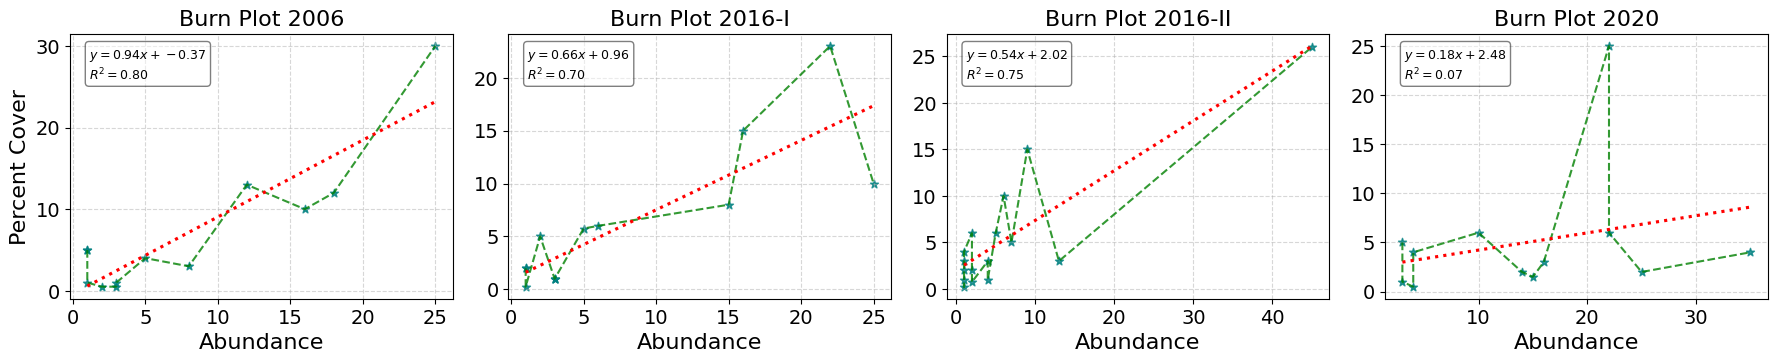

In [21]:
## ABUNDANCE VS PERCENTAGE COVER ANALYSIS

import matplotlib.pyplot as plt
from scipy.stats import linregress


# Define data
years = ['2006', '2016-I', '2016-II', '2020']

abundance_all = [
    [18, 16, 25, 2, 12, 1, 5, 8, 3, 1, 3, 1],
    [16, 22, 3, 6, 2, 25, 15, 3, 5, 1, 3, 1, 1],
    [5, 7, 9, 1, 45, 4, 4, 2, 13, 2, 6, 1, 1, 2, 1, 1],
    # [10, 15, 5, 30, 45, 4, 4, 10, 4, 2],
    [16, 10, 4, 22, 14, 35, 4, 15, 3, 22, 25, 3]
]

percent_cover_all = [
    [12, 10, 30, 0.5, 13, 5, 4, 3, 0.5, 5, 1, 1],
    [15, 23, 1, 6, 5, 10, 8, 1, 5.75, 2, 1, 2, 0.25],
    [6, 5, 15, 3, 26, 3, 1, 6, 3, 2, 10, 2, 0.25, 0.75, 1, 4],
    # [1, 0.25, 2, 46, 10, 5, 4, 1, 0.25, 0.5],
    [3, 6, 0.5, 25, 2, 4, 4, 1.5, 5, 6, 2, 1]
]

colors = ['blue', 'green', 'orange', 'red', 'purple']
markers = ['o', 's', 'D', '^', 'v']

# Set up figure with 5 subplots (1 row, 5 columns)
fig, axes = plt.subplots(1, 4, figsize=(18, 4), sharex=False, sharey=False)

# Plot per year
for i, ax in enumerate(axes):
    abund = abundance_all[i]
    cover = percent_cover_all[i]

    # Sort by abundance for clean lines
    sorted_pairs = sorted(zip(abund, cover), key=lambda x: x[0])
    abund_sorted, cover_sorted = zip(*sorted_pairs)

    ax.scatter(abund_sorted, cover_sorted, color='teal', marker='*', alpha=0.8)
    ax.plot(abund_sorted, cover_sorted, linestyle='--', color='green', alpha=0.8)

    # Regression line
    sns.regplot(x=np.array(abund_sorted), y=np.array(cover_sorted), ax=ax, color='red', ci=None, scatter=False, line_kws={"linestyle": ":"})

    # Compute fit stats
    slope, intercept, r_value, p_value, std_err = linregress(abund_sorted, cover_sorted)

    # Display stats as equation and R²
    eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"
    ax.text(0.05, 0.95, eq, transform=ax.transAxes,
            fontsize=9, verticalalignment='top', bbox=dict(boxstyle='round', facecolor='white', alpha=0.5))


    ax.set_title(f'Burn Plot {years[i]}')
    ax.set_xlabel('Abundance')
    if i == 0:
        ax.set_ylabel('Percent Cover')
    ax.grid(True, linestyle='--', alpha=0.5)

# plt.suptitle('Abundance vs Percent Cover Across Years', fontsize=14)
plt.tight_layout()
plt.subplots_adjust(top=0.85)
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/abundance_vs_cover_analysis.png', dpi=500)
plt.show()

In [22]:
## Reference Data--> Extract chm, tr, gf and pd for the reference plots

ref_plots_shapefile = gpd.read_file('/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis//burns_lr/ref_plot_shapes/refplot_shapes.shp')

#  Generate Reference Data
def ref_data(chm_map, tr_map, pd_map, gf_map, shapefile):

  raster_chm = rxr.open_rasterio(chm_map, masked = True).squeeze()
  raster_tr = rxr.open_rasterio(tr_map, masked = True).squeeze()
  raster_pd = rxr.open_rasterio(pd_map, masked = True).squeeze()
  raster_gf = rxr.open_rasterio(gf_map, masked = True).squeeze()

  chm = raster_chm.rio.clip([shapefile[0]], shapefile[1])
  chm = np.array(chm)
  tr = raster_tr.rio.clip([shapefile[0]], shapefile[1])
  tr = np.array(tr)
  pd = raster_pd.rio.clip([shapefile[0]], shapefile[1])
  pd = np.array(pd)
  gf = raster_gf.rio.clip([shapefile[0]], shapefile[1])
  gf = np.array(gf)

  ref_data = [np.nanmean(chm), np.nanmean(tr), np.nanmean(pd), np.nanmean(gf)]

  return ref_data

# Extract Shapefiles for available years
geometries = ref_plots_shapefile.geometry.apply(mapping)
geo_2006 = [geometries[1], ref_plots_shapefile.crs]
geo_2016 = [geometries[2], ref_plots_shapefile.crs]
geo_2016_v2 = [geometries[3], ref_plots_shapefile.crs]
geo_2019 = [geometries[4], ref_plots_shapefile.crs]
geo_2020 = [geometries[0], ref_plots_shapefile.crs]

# Corresponding  Reference Vectors
refdata_plot_2018 = ref_data(chm_2018, tr_2018, pd_2018, gf_2018, geo_2006)
refdata_plot_2016 = ref_data(chm_2016, tr_2016, pd_2016, gf_2016, geo_2016)
refdata_plot_2016_v2 = ref_data(chm_17_16, tr_17_16, pd_17_16, gf_17_16, geo_2016_v2)
refdata_plot_2019 = ref_data(chm_2019, tr_2019, pd_2019, gf_2019, geo_2019)
refdata_plot_2020 = ref_data(chm_2017, tr_2017, pd_2017, gf_2017, geo_2020)


In [23]:
## Diversity Vs Structural metrics: MAIN

# Data vector/ Feature vectors for each plots--> Canopy height, top-rugosity, point-density and gap-fraction
refdata_plot_2006 = ref_data(chm_2018, tr_2018, pd_2018, gf_2018, geo_2006)
refdata_plot_2016 = ref_data(chm_2016, tr_2016, pd_2016, gf_2016, geo_2016)
refdata_plot_2016_v2 = ref_data(chm_17_16, tr_17_16, pd_17_16, gf_17_16, geo_2016_v2)
refdata_plot_2019 = ref_data(chm_2019, tr_2019, pd_2019, gf_2019, geo_2019)
refdata_plot_2020 = ref_data(chm_2017, tr_2017, pd_2017, gf_2017, geo_2020)


# Individual metrics per year
chm_years = np.array([refdata_plot_2006[0], refdata_plot_2016[0], refdata_plot_2016_v2[0], refdata_plot_2019[0],  refdata_plot_2020[0]])
tr_years = np.array([refdata_plot_2006[1], refdata_plot_2016[1], refdata_plot_2016_v2[1],refdata_plot_2019[1],   refdata_plot_2020[1]])
pd_years = np.array([refdata_plot_2006[2], refdata_plot_2016[2], refdata_plot_2016_v2[2], refdata_plot_2019[2],  refdata_plot_2020[2]])
gf_years = np.array([refdata_plot_2006[3], refdata_plot_2016[3], refdata_plot_2016_v2[3], refdata_plot_2019[3],  refdata_plot_2020[3]])


In [24]:
# ## Diversity Vs Structural metrics: TEMP

# # Data vector/ Feature vectors for each plots--> Canopy height, top-rugosity, point-density and gap-fraction
# refdata_plot_2006 = [np.mean(mean_chm_2018), np.mean(mean_tr_2018), np.mean(mean_pd_2018),np.mean(mean_gf_2018)]
# refdata_plot_2016 = [np.mean(mean_chm_2016), np.mean(mean_tr_2016), np.mean(mean_pd_2016),np.mean(mean_gf_2016)]
# refdata_plot_2016_v2 = [np.mean(mean_chm_17_16), np.mean(mean_tr_17_16), np.mean(mean_pd_17_16),np.mean(mean_gf_17_16)]
# refdata_plot_2019 = [np.mean(mean_chm_2019), np.mean(mean_tr_2019), np.mean(mean_pd_2019),np.mean(mean_gf_2019)]
# refdata_plot_2020 = [np.mean(mean_chm_2017), np.mean(mean_tr_2017), np.mean(mean_pd_2017),np.mean(mean_gf_2017)]
# refdata_plot_2022 = [np.mean(mean_chm_2022), np.mean(mean_tr_2022), np.mean(mean_pd_2022),np.mean(mean_gf_2022)]

# # Shannon Diversity Index
# div = [shannon_2018, shannon_2016, shannon_2016_v2, shannon_2019, shannon_2020, shannon_2022]
# shannon_DI = np.array(div)

# # Individual metrics per year
# chm_years = np.array([refdata_plot_2006[0], refdata_plot_2016[0], refdata_plot_2016_v2[0], refdata_plot_2019[0],  refdata_plot_2020[0]])
# tr_years = np.array([refdata_plot_2006[1], refdata_plot_2016[1], refdata_plot_2016_v2[1],refdata_plot_2019[1],   refdata_plot_2020[1]])
# pd_years = np.array([refdata_plot_2006[2], refdata_plot_2016[2], refdata_plot_2016_v2[2], refdata_plot_2019[2],  refdata_plot_2020[2]])
# gf_years = np.array([refdata_plot_2006[3], refdata_plot_2016[3], refdata_plot_2016_v2[3], refdata_plot_2019[3],  refdata_plot_2020[3]])

# # Statistics of metrics per year:

# # Magnitude of vector per year
# magnitude_2006 = np.linalg.norm(refdata_plot_2006)
# magnitude_2016 = np.linalg.norm(refdata_plot_2016)
# magnitude_2016_v2 = np.linalg.norm(refdata_plot_2016_v2)
# magnitude_2019 = np.linalg.norm(refdata_plot_2019)
# magnitude_2020 = np.linalg.norm(refdata_plot_2020)

# magnitude = np.array([magnitude_2006, magnitude_2016, magnitude_2016_v2, magnitude_2019, magnitude_2020])

# # Feature Entropy

# from scipy.stats import entropy

# def feature_entropy(vec):
#     vec = np.array(vec)
#     norm_vec = vec / vec.sum()
#     return entropy(norm_vec)

# entropies = [
#     feature_entropy(refdata_plot_2006),
#     feature_entropy(refdata_plot_2016),
#     feature_entropy(refdata_plot_2016_v2),
#     feature_entropy(refdata_plot_2019),
#     feature_entropy(refdata_plot_2020)
# ]

# # Principal Component
# from sklearn.decomposition import PCA

# all_struct = np.vstack([refdata_plot_2006, refdata_plot_2016,
#                         refdata_plot_2016_v2, refdata_plot_2019, refdata_plot_2020])
# pca = PCA(n_components=1)
# pc1 = pca.fit_transform(all_struct)
# pc1 = pc1.flatten()


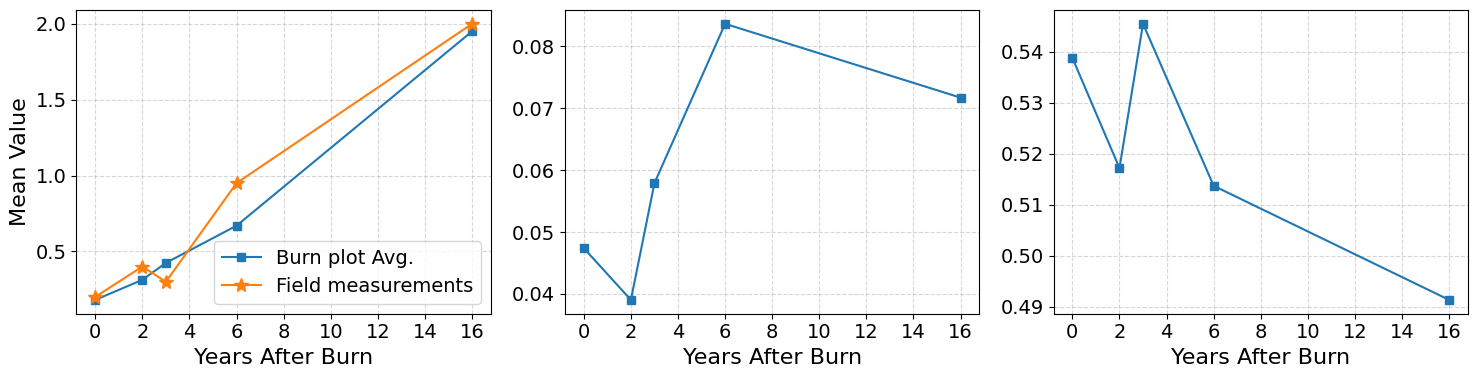

In [25]:
## VEGETATION RECOVERY STATUS: USING FULL BURN YEAR AVERAGE

from matplotlib.ticker import MaxNLocator

## Metrics after 'n' burn years

## Heights in sample plot
h_2006 = 2.0
h_2016 = 1.25
h_2016v2 = 0.65
h_2019 = 0.3
h_2020 = 0.4

actual_height = np.array([2.0, 0.95, 0.3, 0.4, 0.2])

## Individual plot level metrics
chm_years = np.array([refdata_plot_2006[0], refdata_plot_2016[0], refdata_plot_2019[0],  refdata_plot_2020[0]])
tr_years = np.array([refdata_plot_2006[1], refdata_plot_2016[1], refdata_plot_2019[1],   refdata_plot_2020[1]])
pd_years = np.array([refdata_plot_2006[2], refdata_plot_2016[2], refdata_plot_2019[2],  refdata_plot_2020[2]])
gf_years = np.array([refdata_plot_2006[3], refdata_plot_2016[3], refdata_plot_2019[3],  refdata_plot_2020[3]])

## Full burn plot averages
refdata_plot_2006_FBY = [np.nanmean(mean_chm_2018), np.nanmean(mean_tr_2018), np.nanmean(mean_pd_2018), np.nanmean(mean_gf_2018)]
refdata_plot_2016_FBY = [np.nanmean(mean_chm_2016), np.nanmean(mean_tr_2016), np.nanmean(mean_pd_2016), np.nanmean(mean_gf_2016)]
refdata_plot_2016_v2_FBY = [np.nanmean(mean_chm_17_16), np.nanmean(mean_tr_17_16), np.nanmean(mean_pd_17_16), np.nanmean(mean_gf_17_16)]
refdata_plot_2019_FBY = [np.nanmean(mean_chm_2019), np.nanmean(mean_tr_2019), np.nanmean(mean_pd_2019), np.nanmean(mean_gf_2019)]
refdata_plot_2020_FBY = [np.nanmean(mean_chm_2017), np.nanmean(mean_tr_2017), np.nanmean(mean_pd_2017), np.nanmean(mean_gf_2017)]
refdata_plot_2022_FBY = [np.nanmean(mean_chm_2022), np.nanmean(mean_tr_2022), np.nanmean(mean_pd_2022), np.nanmean(mean_gf_2022)]

chm_years_FBY = np.array([refdata_plot_2006_FBY[0], refdata_plot_2016_FBY[0], refdata_plot_2019_FBY[0],  refdata_plot_2020_FBY[0], refdata_plot_2022_FBY[0]])
tr_years_FBY = np.array([refdata_plot_2006_FBY[1], refdata_plot_2016_FBY[1], refdata_plot_2019_FBY[1],   refdata_plot_2020_FBY[1], refdata_plot_2022_FBY[1]])
pd_years_FBY = np.array([refdata_plot_2006_FBY[2], refdata_plot_2016_FBY[2], refdata_plot_2019_FBY[2],  refdata_plot_2020_FBY[2], refdata_plot_2022_FBY[2]])
gf_years_FBY = np.array([refdata_plot_2006_FBY[3], refdata_plot_2016_FBY[3], refdata_plot_2019_FBY[3],  refdata_plot_2020_FBY[3], refdata_plot_2022_FBY[3]])

years = ['2006', '2016', '2019', '2020', '2022']
years_after_burn = [16, 6, 3, 2, 0]

# Create figure with 4 subplots
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# Plot data
# axes[0].plot(years_after_burn, chm_years, marker='*', label='Ref Plot')
axes[0].plot(years_after_burn, chm_years_FBY, marker='s', label='Burn plot Avg.')
axes[0].plot(years_after_burn, actual_height, marker='*', markersize=10, label='Field measurements')
# axes[0].set_title('Canopy Height')
axes[0].set_ylabel('Mean Value')
axes[0].legend(loc = 'lower right')


# axes[0][1].plot(years_after_burn, tr_years, marker='*', label='Ref Plot')
axes[1].plot(years_after_burn, tr_years_FBY, marker='s', label='Burn plot Avg.')
# axes[1].set_title('Top Rugosity')

# axes[1][1].plot(years_after_burn, gf_years, marker='*', label='Ref Plot')
axes[2].plot(years_after_burn, gf_years_FBY, marker='s', label='Burn plot Avg.')
# axes[2].set_title('Surface Gap Ratio')

# Set x-label for all subplots and enable grid
for ax in axes:
        ax.set_xlabel('Years After Burn')
        ax.grid(True, linestyle='--', alpha=0.5)
        ax.xaxis.set_major_locator(MaxNLocator(integer=True))

# plt.suptitle('Vegetation Recovery Status')
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/vegetation_recovery_analysis.png', dpi=500)
plt.show()

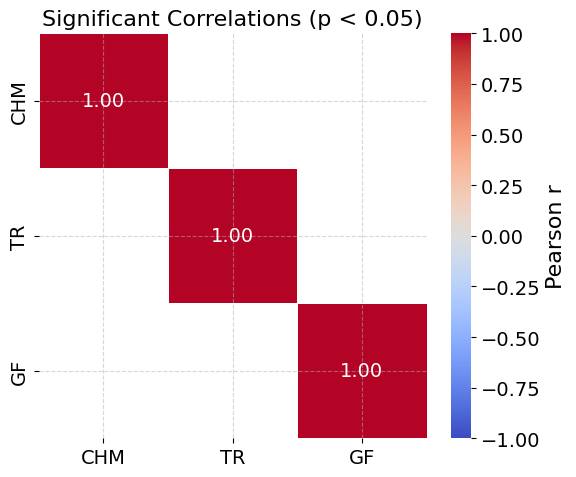

In [26]:
## CORRELATION BETWEEN METRICS FOR ALL BURN YEAR SUBPLOTS: V1

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Prepare the data
data = {
    'CHM': chm_years,
    'TR': tr_years,
    'GF': gf_years
}

df = pd.DataFrame(data)

# Compute correlation and p-value matrices
corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
pval_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)

for col1 in df.columns:
    for col2 in df.columns:
        r, p = pearsonr(df[col1], df[col2])
        corr_matrix.loc[col1, col2] = r
        pval_matrix.loc[col1, col2] = p

# Mask non-significant correlations (p >= 0.05)
mask = pval_matrix >= 0.05
sig_corr = corr_matrix.mask(mask)

# Plot heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(sig_corr.astype(float), annot=True, fmt=".2f", cmap='coolwarm', vmin=-1, vmax=1,
            mask=sig_corr.isnull(), linewidths=0.5, cbar_kws={"label": "Pearson r"})
plt.title("Significant Correlations (p < 0.05)")
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/metric_correlations.png', dpi=500)
plt.show()

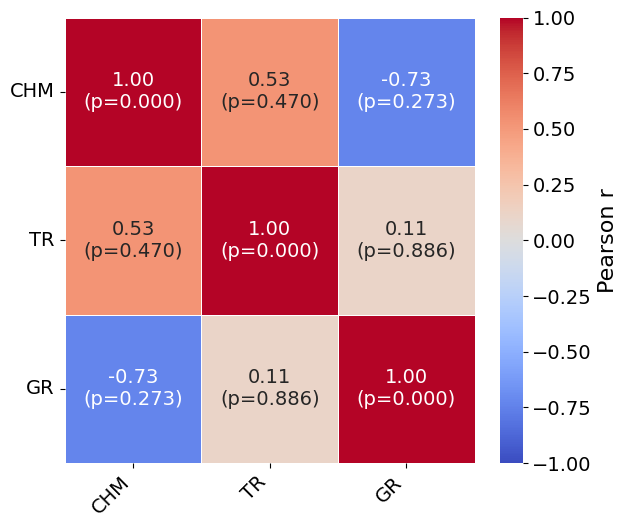

In [27]:
## CORRELATION BETWEEN METRICS FOR ALL BURN YEAR SUBPLOTS: V2

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

# Prepare the data
data = {
    'CHM': chm_years,
    'TR': tr_years,
    'GR': gf_years
}
df = pd.DataFrame(data)

# Compute correlation and p-value matrices
corr_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
pval_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=float)
annot_matrix = pd.DataFrame(index=df.columns, columns=df.columns, dtype=str)

for col1 in df.columns:
    for col2 in df.columns:
        r, p = pearsonr(df[col1], df[col2])
        corr_matrix.loc[col1, col2] = r
        pval_matrix.loc[col1, col2] = p
        annot_matrix.loc[col1, col2] = f"{r:.2f}\n(p={p:.3f})"

# Plot heatmap with annotations
plt.figure(figsize=(6.5, 5.5))
sns.heatmap(
    corr_matrix.astype(float),
    annot=annot_matrix,
    fmt='',
    cmap='coolwarm',
    vmin=-1,
    vmax=1,
    linewidths=0.5,
    cbar_kws={"label": "Pearson r"}
)
# plt.title("Correlation Matrix with P-Values", fontsize=13)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/metric_correlations_w_pvals.png', dpi=500)
plt.show()

In [28]:
## -----------NEW BLOCK---------

In [29]:
## HOW DOES STRUCTURE RELATES TO DIVERSITY FOR DIFFERENT BURN YEARS?

# Burn years:
BY = ['2006', '2016', '2016v2', '2020', '2022']

# Corresponding shannon diversity index
div = [shannon_2018, shannon_2016, shannon_2016_v2, shannon_2020, shannon_2022]
shannon_DI = np.array(div)

## Full burn plot averages
refdata_plot_2006_FBY = [np.nanmean(mean_chm_2018), np.nanmean(mean_tr_2018), np.nanmean(mean_pd_2018), np.nanmean(mean_gf_2018)]
refdata_plot_2016_FBY = [np.nanmean(mean_chm_2016), np.nanmean(mean_tr_2016), np.nanmean(mean_pd_2016), np.nanmean(mean_gf_2016)]
refdata_plot_2016_v2_FBY = [np.nanmean(mean_chm_17_16), np.nanmean(mean_tr_17_16), np.nanmean(mean_pd_17_16), np.nanmean(mean_gf_17_16)]
refdata_plot_2019_FBY = [np.nanmean(mean_chm_2019), np.nanmean(mean_tr_2019), np.nanmean(mean_pd_2019), np.nanmean(mean_gf_2019)]
refdata_plot_2020_FBY = [np.nanmean(mean_chm_2017), np.nanmean(mean_tr_2017), np.nanmean(mean_pd_2017), np.nanmean(mean_gf_2017)]
refdata_plot_2022_FBY = [np.nanmean(mean_chm_2022), np.nanmean(mean_tr_2022), np.nanmean(mean_pd_2022), np.nanmean(mean_gf_2022)]

## ONLY RELEVANT METRICS ARE CHM, TR AND GF SINCE TR IS PROPORTIONAL TO PD AS PER OUR ANALYSIS
chm_years_FBY = np.array([refdata_plot_2006_FBY[0], refdata_plot_2016_FBY[0], refdata_plot_2016_v2_FBY[0], refdata_plot_2020_FBY[0], refdata_plot_2022_FBY[0]])
tr_years_FBY = np.array([refdata_plot_2006_FBY[1], refdata_plot_2016_FBY[1], refdata_plot_2016_v2_FBY[1], refdata_plot_2020_FBY[1], refdata_plot_2022_FBY[1]])
gf_years_FBY = np.array([refdata_plot_2006_FBY[3], refdata_plot_2016_FBY[3], refdata_plot_2016_v2_FBY[3], refdata_plot_2020_FBY[3], refdata_plot_2022_FBY[3]])


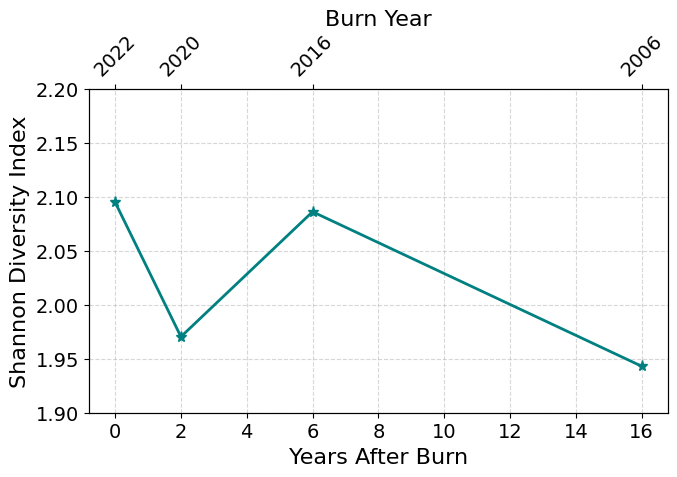

In [30]:
## Years after burn vs diversity--> Diversity Recovery

import matplotlib.pyplot as plt
import numpy as np

# Input data
years_after_burn = [16, 6, 2, 0]
burn_years = ['2006', '2016', '2020', '2022']
shannon_DI_new = np.array([shannon_2018, shannon_2016, shannon_2020, shannon_2022])

# Sort by years_after_burn (in case not sorted)
sorted_idx = np.argsort(years_after_burn)
years_after_burn = np.array(years_after_burn)[sorted_idx]
burn_years = np.array(burn_years)[sorted_idx]
shannon_DI_new = shannon_DI_new[sorted_idx]

# Plot
fig, ax = plt.subplots(figsize=(7, 5))

# Main axis: years after burn
ax.plot(years_after_burn, shannon_DI_new, marker='*', markersize=8, linewidth=2, color='teal')
ax.set_xlabel('Years After Burn')
ax.set_ylabel('Shannon Diversity Index')
# ax.set_xlim(0, 17)
ax.set_ylim(1.9, 2.2)
ax.grid(which='both', linestyle='--', alpha=0.5)

# Twin axis for burn years
ax2 = ax.twiny()
ax2.set_xlim(ax.get_xlim())
ax2.set_xticks(years_after_burn)
ax2.set_xticklabels(burn_years)
ax2.set_xlabel('Burn Year')
ax2.grid(False)
for tick in ax2.get_xticklabels():
    tick.set_rotation(45)
    tick.set_ha('center')

# Additional styling
ax.tick_params()
ax2.tick_params()
# ax.set_title("Diversity Recovery Over Time Since Fire", fontsize=14, pad=15)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/diversity_recovery.png', dpi=500)
plt.show()


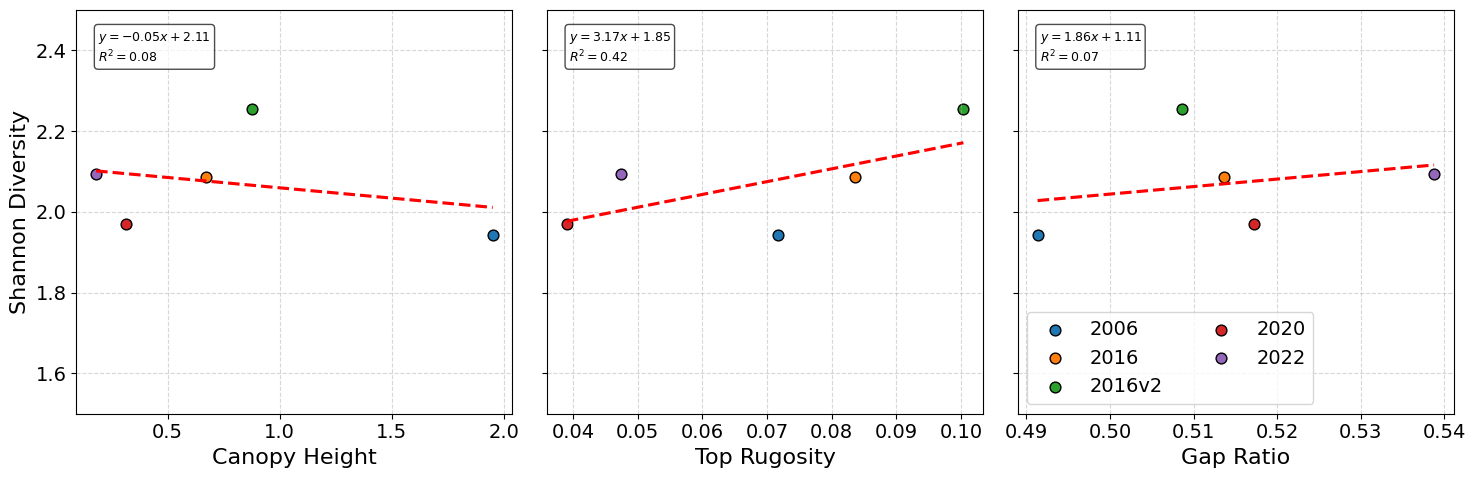

In [31]:
## PLOT

metrics = {'Canopy Height': chm_years_FBY, 'Top Rugosity': tr_years_FBY, 'Gap Ratio': gf_years_FBY}
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, x_vals) in zip(axs, metrics.items()):
    slope, intercept, r_value, p_value, std_err = linregress(x_vals, shannon_DI)
    reg_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"

    for i in range(len(BY)):
        ax.scatter(x_vals[i], shannon_DI[i], s=60, edgecolor='black', label=f'{BY[i]}')
    sns.regplot(x=x_vals, y=shannon_DI, scatter=False, ci=None, ax=ax, color='red', line_kws={"linestyle": "--"})
    ax.set_xlabel(label)
    ax.text(0.05, 0.95, reg_eq, transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.grid(True, linestyle='--', alpha=0.5)

axs[0].set_ylabel('Shannon Diversity')
axs[-1].legend(ncols=2)
plt.ylim(1.5, 2.5)
plt.tight_layout()
plt.show()


In [32]:
## Correlation Analysis

from scipy.stats import pearsonr, spearmanr

def corr_report(x, y, label):
    r, p = pearsonr(x, y)
    rho, ps = spearmanr(x, y)
    print(f"{label} — Pearson r: {r:.2f}, p={p:.3f} | Spearman rho: {rho:.2f}, p={ps:.3f}")


print('Correlation of metric with percentage cover based shannon diversity index:\n')

corr_report(chm_years_FBY, shannon_DI, "CHM")
corr_report(tr_years_FBY, shannon_DI, "TR")
corr_report(gf_years_FBY, shannon_DI, "GR")

Correlation of metric with percentage cover based shannon diversity index:

CHM — Pearson r: -0.29, p=0.636 | Spearman rho: -0.30, p=0.624
TR — Pearson r: 0.65, p=0.235 | Spearman rho: 0.50, p=0.391
GR — Pearson r: 0.26, p=0.677 | Spearman rho: 0.30, p=0.624



Top 5 Weight Combinations by R²:
TR: 0.50, GR: 0.50, CH: 0.00 -> R² = 0.860
TR: 0.50, GR: 0.45, CH: 0.05 -> R² = 0.860
TR: 0.45, GR: 0.50, CH: 0.05 -> R² = 0.847
TR: 0.45, GR: 0.45, CH: 0.10 -> R² = 0.838
TR: 0.40, GR: 0.50, CH: 0.10 -> R² = 0.827


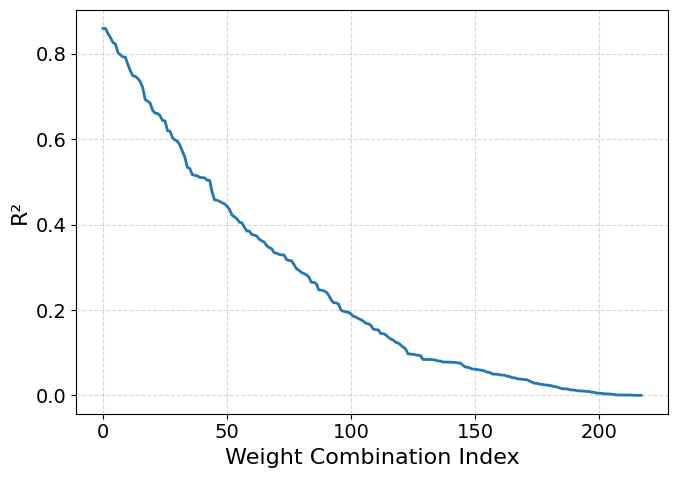

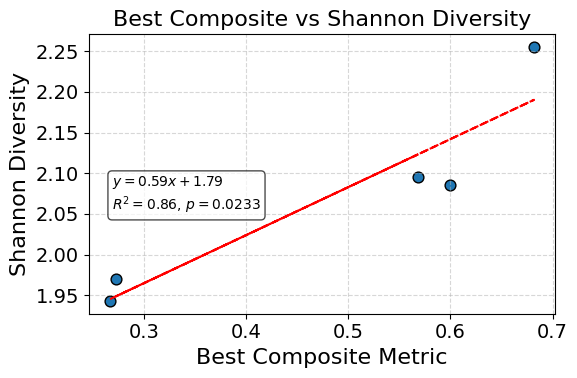

In [33]:
## ANALYSING IF ANY COMBINATION OF THESE METRICS CAN RELATE TO THE DIVERSITY BETTER

import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import linregress
import itertools

# Metrics
TR = np.array(tr_years_FBY)
GR = np.array(gf_years_FBY)
CHM = np.array(chm_years_FBY)
Y = np.array(shannon_DI)

# Normalize to [0,1] for fair combination
def normalize(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))

# Normalized
TR_n = normalize(TR)
GR_n = normalize(GR)
CHM_n = normalize(CHM)

# --- Try all weight combos (TR, GR, RATIO) that sum to 1, in steps of 0.1 ---
step = 0.05
weights = []
r2_scores = []

for w1 in np.arange(0, 1+step, step):
    for w2 in np.arange(0, 1-w1+step, step):
        w3 = 1.0 - w1 - w2
        if w3 < 0 or w3 > 1:
            continue
        composite = w1 * TR_n + w2 * GR_n + w3 * CHM_n
        slope, intercept, r, p, _ = linregress(composite, Y)
        r2 = r**2
        weights.append((w1, w2, w3))
        r2_scores.append(r2)

# --- Sort by R² ---
sorted_results = sorted(zip(weights, r2_scores), key=lambda x: x[1], reverse=True)
top_n = 5

print(f"\nTop {top_n} Weight Combinations by R²:")
for i in range(top_n):
    (w1, w2, w3), r2 = sorted_results[i]
    print(f"TR: {w1:.2f}, GR: {w2:.2f}, CH: {w3:.2f} -> R² = {r2:.3f}")

# --- Plot R² for all combinations ---
plt.figure(figsize=(7, 5))
all_r2 = [r for _, r in sorted_results]
plt.plot(range(len(all_r2)), all_r2, linewidth=2)
plt.xlabel("Weight Combination Index")
plt.ylabel("R²")
# plt.title("R² for Different Metric Weight Combinations")
plt.grid(which='both', linestyle='--', alpha=0.5)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/weight_combination_vs_R2.png', dpi=500)
plt.show()

# ||<--- Plot best-fitting composite vs Shannon Diversity --->||
best_weights, best_r2 = sorted_results[0]
composite_best = best_weights[0] * TR_n + best_weights[1] * GR_n + best_weights[2] * CHM_n
slope, intercept, r, p, _ = linregress(composite_best, Y)
reg_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {best_r2:.2f}$, $p = {p:.4f}$"

plt.figure(figsize=(6, 4))
plt.scatter(composite_best, Y, s=60, edgecolor='black')
plt.plot(composite_best, slope * composite_best + intercept, 'r--')
plt.xlabel("Best Composite Metric")
plt.ylabel("Shannon Diversity")
plt.title("Best Composite vs Shannon Diversity")
plt.text(0.05, 0.5, reg_eq, transform=plt.gca().transAxes,
         fontsize=10, verticalalignment='top',
         bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
# plt.ylim(1, 2.5)
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


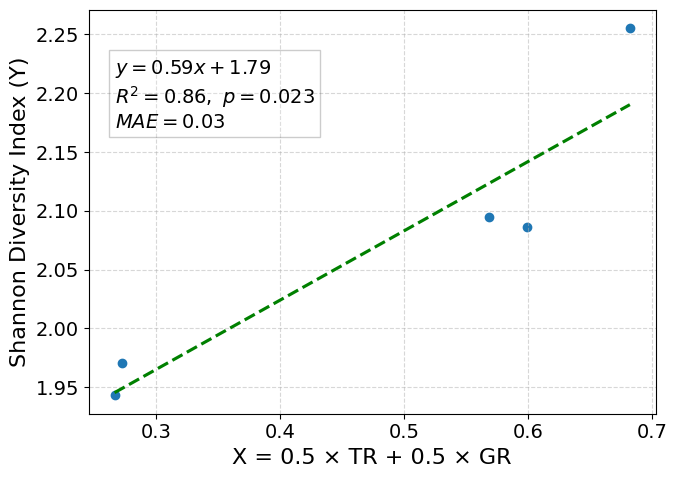

In [39]:
from sklearn.metrics import mean_absolute_error

## VALIDATION

# combined metric
X = 0.5 * TR_n + 0.5 * GR_n

# linear regression
slope, intercept, r_value, p_value, std_err = linregress(X, Y)

# Predict values
Y_pred = slope * X + intercept

# Compute MAE
mae = mean_absolute_error(Y, Y_pred)

# Plot scatter and regression line
plt.figure(figsize=(7, 5))
plt.scatter(X, Y)
sns.regplot(x=X, y=Y, ci=None, scatter=False, color='green', line_kws={"linestyle": "--"})

# regression equation text
eq_text = f'$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f},\ p = {p_value:.3f}$\n$MAE={mae:.2f}$'
plt.text(min(X), 2.23, eq_text, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.2))

plt.xlabel('X = 0.5 × TR + 0.5 × GR')
plt.ylabel('Shannon Diversity Index (Y)')
# plt.ylim(1,2.5)
# plt.legend()
# plt.title('Regression Plot with Equation')
plt.grid(which='both', linestyle='--', alpha=0.5)
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/model_performance.png', dpi=500)
plt.tight_layout()
plt.show()

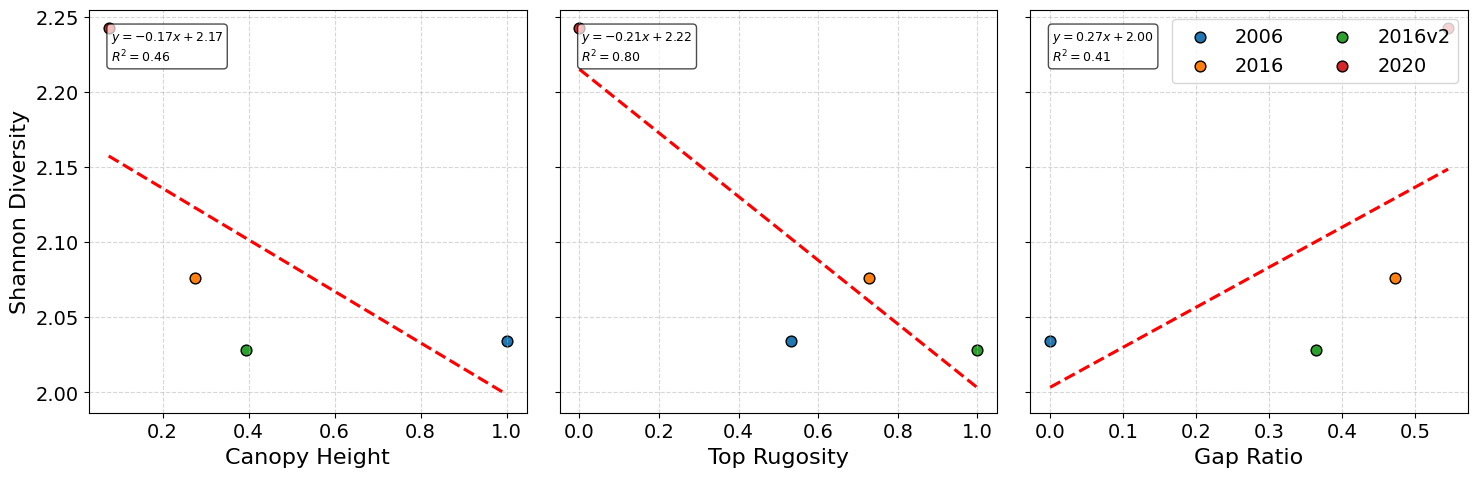

In [ ]:
## TESTING IF THIS MODEL WORKS ON ABUNDANCE BASED DIVERSITY INDEX: using just available 2006, 2016v1, 2016v2 and 2020 burn plots.

X1_abd = CHM_n[:4]
X2_abd = TR_n[:4]
X3_abd = GR_n[:4]
Y_abd = abd_based_div


## PLOT
burn_years = ['2006', '2016', '2016v2', '2020']
metrics = {'Canopy Height': X1_abd, 'Top Rugosity': X2_abd, 'Gap Ratio': X3_abd}
fig, axs = plt.subplots(1, 3, figsize=(15, 5), sharey=True)

for ax, (label, x_vals) in zip(axs, metrics.items()):
    slope, intercept, r_value, p_value, std_err = linregress(x_vals, Y_abd)
    reg_eq = f"$y = {slope:.2f}x + {intercept:.2f}$\n$R^2 = {r_value**2:.2f}$"

    for i in range(len(burn_years)):
        ax.scatter(x_vals[i], Y_abd[i], s=60, edgecolor='black', label=f'{burn_years[i]}')
    sns.regplot(x=x_vals, y=Y_abd, scatter=False, ci=None, ax=ax, color='red', line_kws={"linestyle": "--"})
    ax.set_xlabel(label)
    ax.text(0.05, 0.95, reg_eq, transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.7))
    ax.grid(True, linestyle='--', alpha=0.5)
    # ax.plot([16, 6, 6, 2 ], Y_abd, marker='*', markersize=8, linewidth=2, color='teal')

axs[0].set_ylabel('Shannon Diversity')
axs[-1].legend(ncols=2)
# plt.ylim(1.5, 2.5)
plt.tight_layout()
plt.show()

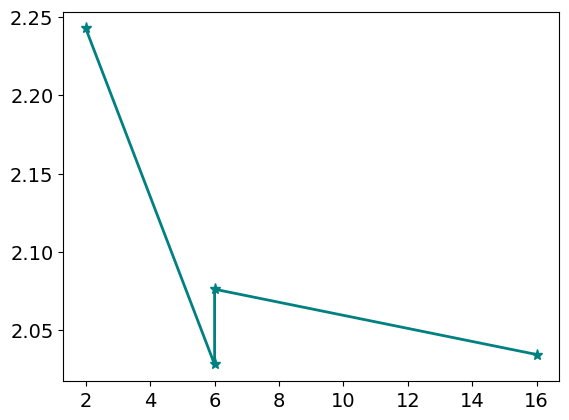

In [ ]:
plt.plot([16, 6, 6, 2 ], Y_abd, marker='*', markersize=8, linewidth=2, color='teal')

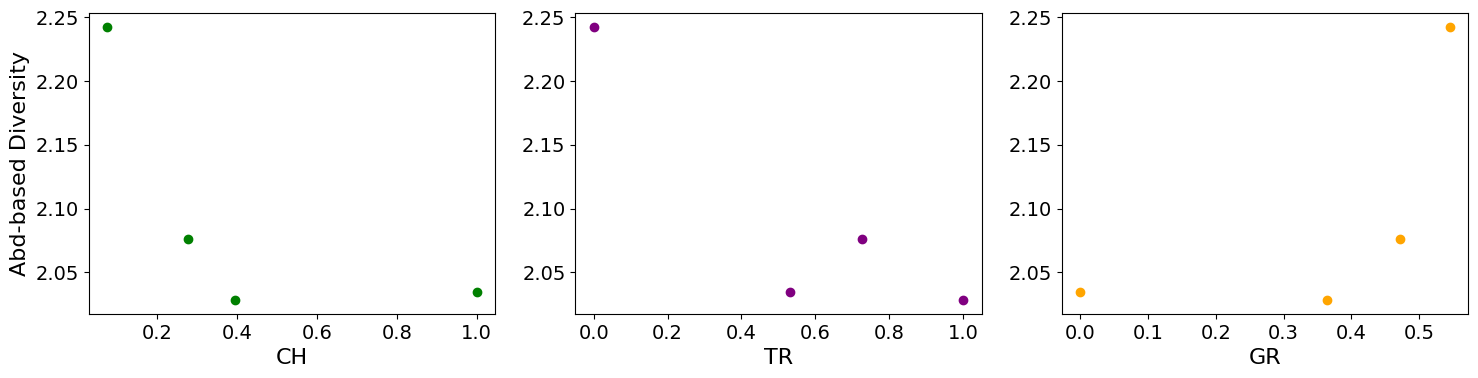

In [ ]:
## VISUAL TREND

import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 3, figsize=(15, 4))

axs[0].scatter(X1_abd, Y_abd, color='green')
# axs[0].set_title('TR vs Abundance Diversity')
axs[0].set_xlabel('CH')
axs[0].set_ylabel('Abd-based Diversity')

axs[1].scatter(X2_abd, Y_abd, color='purple')
# axs[1].set_title('GR vs Abundance Diversity')
axs[1].set_xlabel('TR')

axs[2].scatter(X3_abd, Y_abd, color='orange')
# axs[2].set_title('CH vs Abundance Diversity')
axs[2].set_xlabel('GR')

plt.tight_layout()
plt.show()


In [ ]:
from scipy.stats import pearsonr, spearmanr

def corr_report(x, y, label):
    r, p = pearsonr(x, y)
    rho, ps = spearmanr(x, y)
    print(f"{label} — Pearson r: {r:.2f}, p={p:.3f} | Spearman rho: {rho:.2f}, p={ps:.3f}")

print('Correlation of metric with abundance based shannon diversity index:\n')

corr_report(X1_abd, Y_abd, "CHM")
corr_report(X2_abd, Y_abd, "TR")
corr_report(X3_abd, Y_abd, "GR")


Correlation of metric with abundance based shannon diversity index:

CHM — Pearson r: -0.68, p=0.320 | Spearman rho: -0.80, p=0.200
TR — Pearson r: -0.89, p=0.108 | Spearman rho: -0.80, p=0.200
GR — Pearson r: 0.64, p=0.358 | Spearman rho: 0.80, p=0.200


In [ ]:
## MAKING THE MAPS:

## First combine the chms and gr and normalize them across years to use the model:

# ## For each Plot both structural metrices to single array: NI

# bdata_2022 = [ [mean_chm_2022[i], mean_gf_2022[i]] for i in range(len(plots_2022))] # year 2022
# bdata_2016 = [ [mean_chm_2016[i], mean_gf_2016[i]] for i in range(len(plots_2016))] # year 2016
# bdata_2018 = [ [mean_chm_2018[i], mean_gf_2018[i]] for i in range(len(plots_2018))] # year 2006
# bdata_2019 = [ [mean_chm_2019[i], mean_gf_2019[i]] for i in range(len(plots_2019))]  # year 2019
# bdata_17_16 = [ [mean_chm_17_16[i], mean_gf_17_16[i]] for i in range(len(plots_17_16))] # year 2016v2
# bdata_2017 = [ [mean_chm_2017[i],  mean_gf_2017[i]] for i in range(len(plots_2017))]  # # year 2017

## Normalize them across burn years for all the plots:

# Combine all tr and gr values across years
all_tr = (
    mean_tr_2022 + mean_tr_2016 + mean_tr_2018 +
    mean_tr_2019 + mean_tr_17_16 + mean_tr_2017
)

all_gf = (
    mean_gf_2022 + mean_gf_2016 + mean_gf_2018 +
    mean_gf_2019 + mean_gf_17_16 + mean_gf_2017
)

# Compute global min and max
min_tr, max_tr = min(all_tr), max(all_tr)
min_gf, max_gf = min(all_gf), max(all_gf)

# Define normalization functions
def normalize(value, min_val, max_val):
    return (value - min_val) / (max_val - min_val) if max_val > min_val else 0.0

def normalize_list(values, min_val, max_val):
    return [normalize(v, min_val, max_val) for v in values]

# Normalize and pair data per year

bdata_2006_n = [[normalize(mean_tr_2018[i], min_tr, max_tr),
               normalize(mean_gf_2018[i], min_gf, max_gf)] for i in range(len(plots_2018))]

bdata_2016_n = [[normalize(mean_tr_2016[i], min_tr, max_tr),
               normalize(mean_gf_2016[i], min_gf, max_gf)] for i in range(len(plots_2016))]

bdata_2016v2_n = [[normalize(mean_tr_17_16[i], min_tr, max_tr),
                normalize(mean_gf_17_16[i], min_gf, max_gf)] for i in range(len(plots_17_16))]

bdata_2019_n = [[normalize(mean_tr_2019[i], min_tr, max_tr),
               normalize(mean_gf_2019[i], min_gf, max_gf)] for i in range(len(plots_2019))]

bdata_2020_n = [[normalize(mean_tr_2017[i], min_tr, max_tr),
               normalize(mean_gf_2017[i], min_gf, max_gf)] for i in range(len(plots_2017))]

bdata_2022_n = [[normalize(mean_tr_2022[i], min_tr, max_tr),
               normalize(mean_gf_2022[i], min_gf, max_gf)] for i in range(len(plots_2022))]


In [ ]:
## USE OUR MODEL SUCH WHICH COMBINED TR AND GR AS --> 0.5 * TR_n + 0.5 * GR_n TO GIVE ESTIMATE OF DIVERSITY PER SMALLER PLOTS

import numpy as np

def predict_diversity(subplot_vectors):

    predicted_diversities = []

    for vec in subplot_vectors:
        tr_n = vec[0]
        gr_n = vec[1]

        # Diversity model
        X = 0.5 * tr_n + 0.5 * gr_n
        D_pred = 0.59 * X + 1.79
        predicted_diversities.append(D_pred)

    return predicted_diversities

In [ ]:
## Apply the model across all burn years
burn_years = ['2006', '2016', '2016v2', '2019', '2020', '2022']

est_div_2006 = predict_diversity(bdata_2006_n)
est_div_2016 = predict_diversity(bdata_2016_n)
est_div_2016v2 = predict_diversity(bdata_2016v2_n)
est_div_2019 = predict_diversity(bdata_2019_n)    ## Just Estimate, dont use true
est_div_2020 = predict_diversity(bdata_2020_n)
est_div_2022 = predict_diversity(bdata_2022_n)

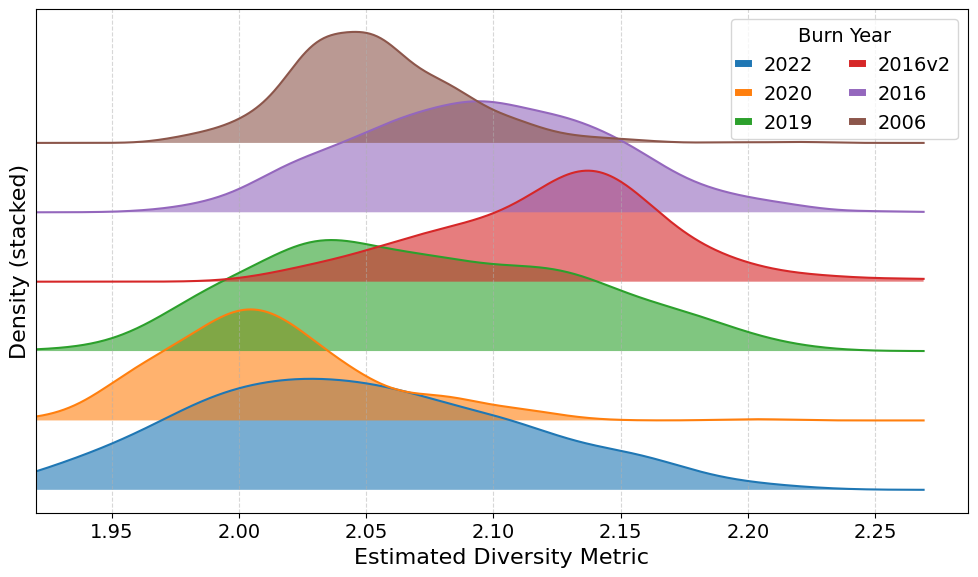

In [ ]:
## RIDGE PLOT FOR ESTIMATE ANALYSIS

from scipy.stats import gaussian_kde

burn_years = ['2006', '2016', '2016v2', '2019', '2020', '2022']
estimates = [
    est_div_2006,
    est_div_2016,
    est_div_2016v2,
    est_div_2019,
    est_div_2020,
    est_div_2022
]

# Combine data into DataFrame
data = pd.concat(
    [pd.DataFrame({'Burn Year': year, 'Estimated Diversity': est}) for year, est in zip(burn_years, estimates)],
    ignore_index=True
)

# Unique burn years reversed to plot earliest at bottom
years = burn_years[::-1]

plt.figure(figsize=(10, 6))

vertical_spacing = 0.5
x_min = min(data['Estimated Diversity'])
x_max = max(data['Estimated Diversity'])
x_vals = np.linspace(x_min, x_max, 500)

for i, year in enumerate(years):
    subset = data[data['Burn Year'] == year]['Estimated Diversity'].dropna()
    subset = subset[np.isfinite(subset)]
    subset = subset.values

    # Compute KDE
    kde = gaussian_kde(subset)
    y_vals = kde(x_vals)

    # Normalize KDE for better visualization (max to 1)
    y_vals = y_vals / y_vals.max()

    # Shift KDE vertically
    y_shifted = y_vals * 0.8 + i * vertical_spacing
    plt.fill_between(x_vals, i * vertical_spacing, y_shifted, alpha=0.6)
    plt.plot(x_vals, y_shifted, label=year)

plt.xlabel('Estimated Diversity Metric')
plt.yticks([])
plt.ylabel('Density (stacked)')
plt.xlim(x_min - 0*(x_max - x_min), x_max + 0.05*(x_max - x_min))
plt.grid(which='both', linestyle='--', alpha=0.5)

# Add legend box for burn years
leg = plt.legend(title='Burn Year', loc='upper right', ncols=2, handlelength=0.5)
for line in leg.get_lines():
    line.set_linewidth(5)
plt.tight_layout()
plt.show()


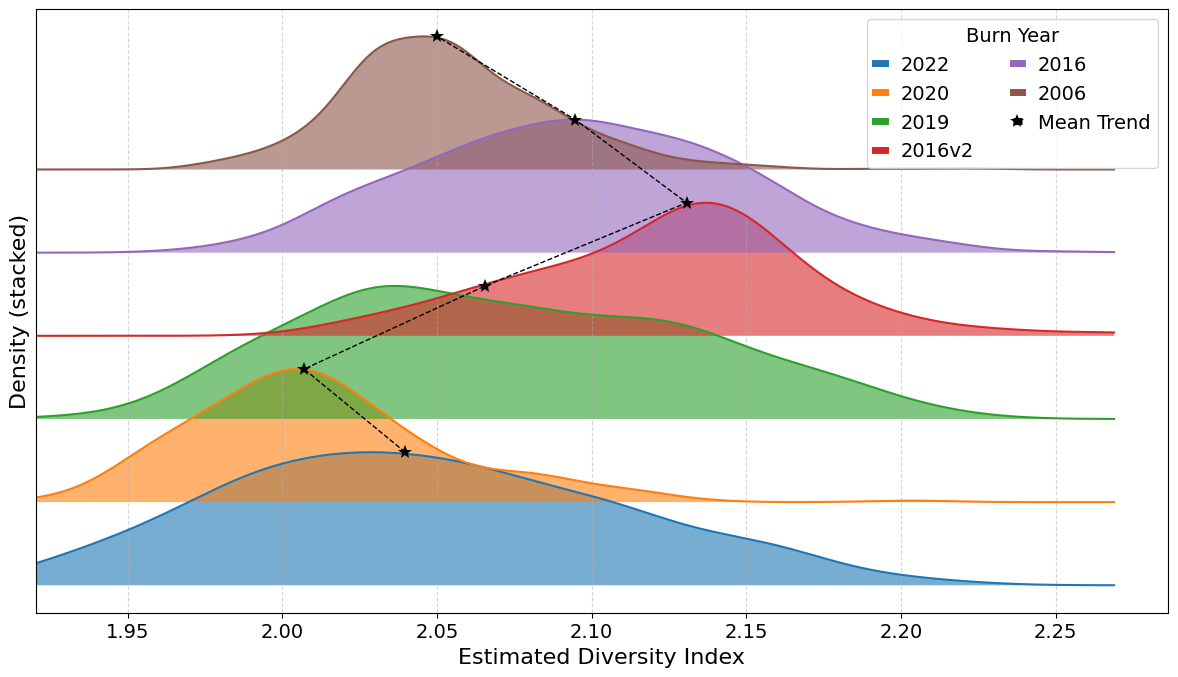

In [ ]:
from scipy.stats import gaussian_kde

burn_years = ['2006', '2016', '2016v2', '2019', '2020', '2022']
estimates = [
    est_div_2006,
    est_div_2016,
    est_div_2016v2,
    est_div_2019,
    est_div_2020,
    est_div_2022
]

# Combine data into DataFrame
data = pd.concat(
    [pd.DataFrame({'Burn Year': year, 'Estimated Diversity': est}) for year, est in zip(burn_years, estimates)],
    ignore_index=True
)

# Unique burn years reversed to plot earliest at bottom
years = burn_years[::-1]

plt.figure(figsize=(12, 7))

vertical_spacing = 0.5
x_min = min(data['Estimated Diversity'])
x_max = max(data['Estimated Diversity'])
x_vals = np.linspace(x_min, x_max, 500)

# Store mean x (diversity) and y (stacked level) for trend line
trend_x = []
trend_y = []

for i, year in enumerate(years):
    subset = data[data['Burn Year'] == year]['Estimated Diversity'].dropna()
    subset = subset[np.isfinite(subset)]
    subset = subset.values

    # Compute KDE
    kde = gaussian_kde(subset)
    y_vals = kde(x_vals)

    # Normalize and vertically shift KDE
    y_vals = y_vals / y_vals.max()
    y_shifted = y_vals * 0.8 + i * vertical_spacing

    # Plot KDE
    plt.fill_between(x_vals, i * vertical_spacing, y_shifted, alpha=0.6)
    plt.plot(x_vals, y_shifted, label=year)

    # Compute mean or KDE peak as x, and y-position to align with vertical level
    mean_x = np.median(subset)
    trend_x.append(mean_x)
    trend_y.append(i * vertical_spacing + 0.8)  # slightly above the KDE for clarity

# Plot trend line
plt.plot(trend_x, trend_y, marker = '*', color='black', label='Mean Trend', linewidth=1, linestyle='--', markersize=10, markeredgewidth=0)

plt.xlabel('Estimated Diversity Index')
plt.yticks([])
plt.ylabel('Density (stacked)')
plt.xlim(x_min, x_max + 0.05*(x_max - x_min))
plt.grid(which='both', linestyle='--', alpha=0.5)

# Add legend box for burn years
leg = plt.legend(title='Burn Year', loc='upper right', ncols=2, handlelength=0.5)
for line in leg.get_lines():
    line.set_linewidth(5)

plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/kde_plot_of_diversity_estimates.png', dpi=500)
plt.show()

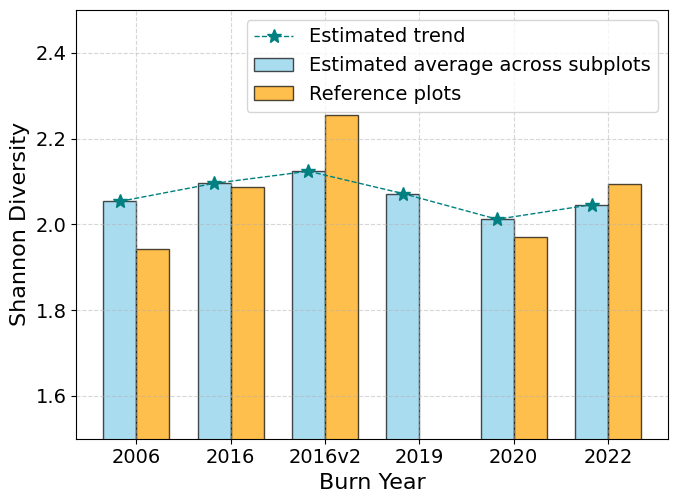

In [ ]:
## HOW DOES AVERAGE OF THESE ESTIMATES RELATE TO GROUND TRUTH (Reference plots)??

# Data
est_div = np.array([
    np.nanmean(est_div_2006),
    np.nanmean(est_div_2016),
    np.nanmean(est_div_2016v2),
    np.nanmean(est_div_2019),
    np.nanmean(est_div_2020),
    np.nanmean(est_div_2022)
])

# Corresponding burn years
burn_years = ['2006', '2016', '2016v2', '2019', '2020', '2022']

# Observed Data
obs_div = np.array(shannon_DI)
obs_div_full = np.array([obs_div[0], obs_div[1], obs_div[2], np.nan, obs_div[3], obs_div[4]])  # np.nan for 2019

# Bar settings
x = np.arange(len(burn_years))
width = 0.35

# Plot
fig, ax = plt.subplots(figsize=(7, 5.25))

# Bars
est_bars = ax.bar(x - width/2, est_div, width, label='Estimated average across subplots', color='skyblue', edgecolor='black', alpha=0.7)
obs_bars = ax.bar(x + width/2, obs_div_full, width, label='Reference plots', color='orange', edgecolor='black', alpha=0.7)

# Add line connecting estimated bars
ax.plot(x - width/2, est_div, color='teal', marker='*', linestyle='--', linewidth=1, alpha=1, markersize=10, label='Estimated trend')

# Labels & formatting
ax.set_xlabel('Burn Year')
ax.set_ylabel('Shannon Diversity')
ax.set_xticks(x)
ax.set_xticklabels(burn_years)
ax.legend(frameon=True)
ax.grid(which= 'both', linestyle='--', alpha=0.5)
plt.ylim(1.5, 2.5)
plt.tight_layout()
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/est_avg_vs_reference_plots.png', dpi=500)
plt.show()

In [ ]:
##  SAVE FOR BURN YEAR 2019

import geopandas as gpd
import numpy as np
from rasterio import features
import rasterio

# Load the shapefile
shapefile = shp_2019.copy()

# Add the alpha values to the shapefile's attribute table
shapefile['div'] = est_div_2019

# Save the updated shapefile
shapefile.to_file('/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis/burns_lr/results_0.25m/new_shapes/shapefile_2019.shp')

# Define the metadata for the raster
with rasterio.open(chm_2019) as src:
  meta = src.meta

# Update meta to use float64 and nodata
meta.update({
    'count': 1,
    'dtype': 'float64',
    'nodata': np.nan
})

# Define output file paths
output_paths = {
    'div': '/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2019.tif',
}

# Rasterize and write each output separately
for key, path in output_paths.items():
    out_image = features.rasterize(
        [(geom, value) for geom, value in zip(shapefile.geometry, shapefile[key])],
        out_shape=(meta['height'], meta['width']),
        transform=meta['transform'],
        fill=np.nan,
        all_touched=True,
        dtype='float64'
    )
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out_image, 1)

print("Saved Raster for Diversity Estimate")

Saved Raster for Diversity Estimate


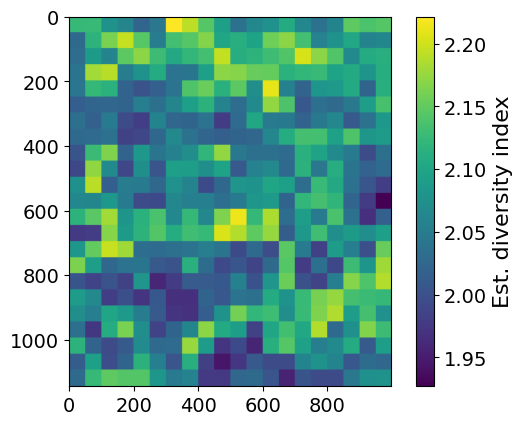

In [ ]:
## LOAD THE ESTIMATE OF DIVERSITY

div_2019 = rasterio.open('/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2019.tif').read(1)

# Find where values are non-zero
nonzero_indices = np.argwhere(div_2019 > 0)

# Get bounding box (min and max rows and cols)
row_min, col_min = nonzero_indices.min(axis=0)
row_max, col_max = nonzero_indices.max(axis=0)

# Crop the array to that bounding box
cropped_alpha = div_2019[row_min:row_max+1, col_min:col_max+1]

plt.imshow(cropped_alpha, cmap='viridis')
# plt.title('2019 Burn Plot')
plt.colorbar(label='Est. diversity index')
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/est_div_2019BP_V2.png', dpi=500)
plt.show()

In [ ]:
##  SAVE FOR BURN YEAR 2006

import geopandas as gpd
import numpy as np
from rasterio import features
import rasterio

# Load the shapefile
shapefile = shp_2018.copy()

# Add the alpha values to the shapefile's attribute table
shapefile['div'] = est_div_2006

# Save the updated shapefile
shapefile.to_file('/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis/burns_lr/results_0.25m/new_shapes/shapefile_2006.shp')

# Define the metadata for the raster
with rasterio.open(chm_2018) as src:
  meta = src.meta

# Update meta to use float64 and nodata
meta.update({
    'count': 1,
    'dtype': 'float64',
    'nodata': np.nan
})

# Define output file paths
output_paths = {
    'div': '/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2006.tif',
}

# Rasterize and write each output separately
for key, path in output_paths.items():
    out_image = features.rasterize(
        [(geom, value) for geom, value in zip(shapefile.geometry, shapefile[key])],
        out_shape=(meta['height'], meta['width']),
        transform=meta['transform'],
        fill=np.nan,
        all_touched=True,
        dtype='float64'
    )
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out_image, 1)

print("Saved Raster for Diversity Estimate")

/usr/local/lib/python3.11/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Raster for Diversity Estimate


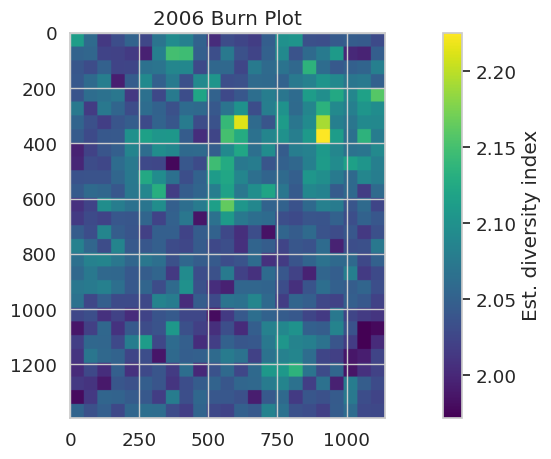

In [ ]:
## LOAD THE ESTIMATE OF DIVERSITY

div_2006 = rasterio.open('/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2006.tif').read(1)

# Find where values are non-zero
nonzero_indices = np.argwhere(div_2006 > 0)

# Get bounding box (min and max rows and cols)
row_min, col_min = nonzero_indices.min(axis=0)
row_max, col_max = nonzero_indices.max(axis=0)

# Crop the array to that bounding box
cropped_alpha = div_2006[row_min:row_max+1, col_min:col_max+1]

plt.imshow(cropped_alpha, cmap='viridis')
plt.title('2006 Burn Plot')
plt.colorbar(label='Est. diversity index')
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/est_div_2006BP.png', dpi=500)
plt.show()

In [ ]:
##  SAVE FOR BURN YEAR 2016

# Load the shapefile
shapefile = shp_2016.copy()

# Add the alpha values to the shapefile's attribute table
shapefile['div'] = est_div_2016

# Save the updated shapefile
shapefile.to_file('/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis/burns_lr/results_0.25m/new_shapes/shapefile_2016.shp')

# Define the metadata for the raster
with rasterio.open(chm_2016) as src:
  meta = src.meta

# Update meta to use float64 and nodata
meta.update({
    'count': 1,
    'dtype': 'float64',
    'nodata': np.nan
})

# Define output file paths
output_paths = {
    'div': '/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2016.tif',
}

# Rasterize and write each output separately
for key, path in output_paths.items():
    out_image = features.rasterize(
        [(geom, value) for geom, value in zip(shapefile.geometry, shapefile[key])],
        out_shape=(meta['height'], meta['width']),
        transform=meta['transform'],
        fill=np.nan,
        all_touched=True,
        dtype='float64'
    )
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out_image, 1)

print("Saved Raster for Diversity Estimate")

/usr/local/lib/python3.11/dist-packages/pyogrio/geopandas.py:710: UserWarning: 'crs' was not provided.  The output dataset will not have projection information defined and may not be usable in other systems.
  write(


Saved Raster for Diversity Estimate


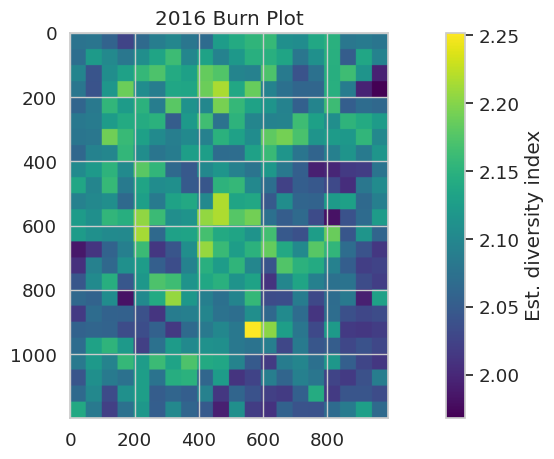

In [ ]:
## LOAD THE ESTIMATE OF DIVERSITY

div_2016 = rasterio.open('/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2016.tif').read(1)

# Find where values are non-zero
nonzero_indices = np.argwhere(div_2016 > 0)

# Get bounding box (min and max rows and cols)
row_min, col_min = nonzero_indices.min(axis=0)
row_max, col_max = nonzero_indices.max(axis=0)

# Crop the array to that bounding box
cropped_alpha = div_2016[row_min:row_max+1, col_min:col_max+1]

plt.imshow(cropped_alpha, cmap='viridis')
plt.title('2016 Burn Plot')
plt.colorbar(label='Est. diversity index')
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/est_div_2016BP.png', dpi=500)
plt.show()

In [ ]:
##  SAVE FOR BURN YEAR 2020

# Load the shapefile
shapefile = shp_2017.copy()

# Add the alpha values to the shapefile's attribute table
shapefile['div'] = est_div_2020

# Save the updated shapefile
shapefile.to_file('/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis/burns_lr/results_0.25m/new_shapes/shapefile_2020.shp')

# Define the metadata for the raster
with rasterio.open(chm_2017) as src:
  meta = src.meta

# Update meta to use float64 and nodata
meta.update({
    'count': 1,
    'dtype': 'float64',
    'nodata': np.nan
})

# Define output file paths
output_paths = {
    'div': '/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2020.tif',
}

# Rasterize and write each output separately
for key, path in output_paths.items():
    out_image = features.rasterize(
        [(geom, value) for geom, value in zip(shapefile.geometry, shapefile[key])],
        out_shape=(meta['height'], meta['width']),
        transform=meta['transform'],
        fill=np.nan,
        all_touched=True,
        dtype='float64'
    )
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out_image, 1)

print("Saved Raster for Diversity Estimate")

Saved Raster for Diversity Estimate


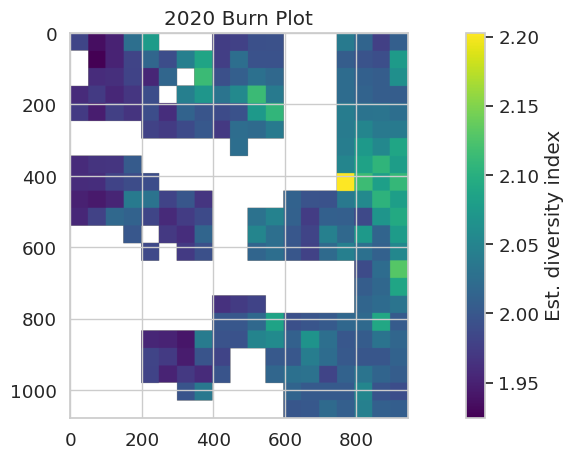

In [ ]:
## LOAD THE ESTIMATE OF DIVERSITY

div_2020 = rasterio.open('/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2020.tif').read(1)

# Find where values are non-zero
nonzero_indices = np.argwhere(div_2020 > 0)

# Get bounding box (min and max rows and cols)
row_min, col_min = nonzero_indices.min(axis=0)
row_max, col_max = nonzero_indices.max(axis=0)

# Crop the array to that bounding box
cropped_alpha = div_2020[row_min:row_max+1, col_min:col_max+1]

plt.imshow(cropped_alpha, cmap='viridis')
plt.title('2020 Burn Plot')
plt.colorbar(label='Est. diversity index')
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/est_div_2020BP.png', dpi=500)
plt.show()

In [ ]:
##  SAVE FOR BURN YEAR 2022

# Load the shapefile
shapefile = shp_2022.copy()

# Add the alpha values to the shapefile's attribute table
shapefile['div'] = est_div_2022

# Save the updated shapefile
shapefile.to_file('/content/drive/MyDrive/work_gdrive/Fynbos_SfM_analysis/burns_lr/results_0.25m/new_shapes/shapefile_2022.shp')

# Define the metadata for the raster
with rasterio.open(chm_2022) as src:
  meta = src.meta

# Update meta to use float64 and nodata
meta.update({
    'count': 1,
    'dtype': 'float64',
    'nodata': np.nan
})

# Define output file paths
output_paths = {
    'div': '/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2022.tif',
}

# Rasterize and write each output separately
for key, path in output_paths.items():
    out_image = features.rasterize(
        [(geom, value) for geom, value in zip(shapefile.geometry, shapefile[key])],
        out_shape=(meta['height'], meta['width']),
        transform=meta['transform'],
        fill=np.nan,
        all_touched=True,
        dtype='float64'
    )
    with rasterio.open(path, 'w', **meta) as dst:
        dst.write(out_image, 1)

print("Saved Raster for Diversity Estimate")

Saved Raster for Diversity Estimate


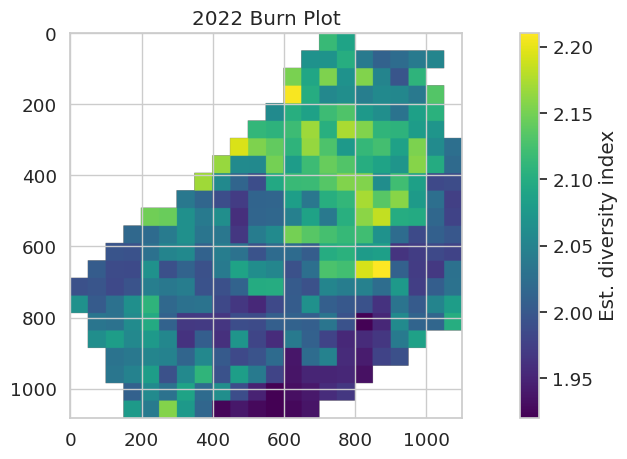

In [ ]:
## LOAD THE ESTIMATE OF DIVERSITY

div_2022 = rasterio.open('/content/drive/MyDrive/fynbos_new_analysis_june2025/Div_Est/est_div_2022.tif').read(1)

# Find where values are non-zero
nonzero_indices = np.argwhere(div_2022 > 0)

# Get bounding box (min and max rows and cols)
row_min, col_min = nonzero_indices.min(axis=0)
row_max, col_max = nonzero_indices.max(axis=0)

# Crop the array to that bounding box
cropped_alpha = div_2022[row_min:row_max+1, col_min:col_max+1]

plt.imshow(cropped_alpha, cmap='viridis')
plt.title('2022 Burn Plot')
plt.colorbar(label='Est. diversity index')
# plt.savefig('/content/drive/MyDrive/fynbos_new_analysis_june2025/est_div_2022BP.png', dpi=500)
plt.show()